Wave Power Assessment (https://github.com/kazuakiuchibori/WavePowerAssessment)

海底地形のDEMデータ(seragaki.csv)をGitHubからダウンロード

In [ ]:
!pip install wget
import wget
file_url = 'https://raw.githubusercontent.com/kazuakiuchibori/WavePowerAssessment/main/seragaki.csv'
wget.download(file_url)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4cf451779df26d38cc0e2ca2ae331d7f46933af32cf5a1ae4160f72f8f14d083
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


'seragaki.csv'

ここからプログラム

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad, dblquad
#from matplotlib import rcParams
#rcParams['font.family'] = 'Times New Roman'
#rcParams['font.size'] = 12

図に表示される地名

In [ ]:
# place text
place = '@Seragaki'

海底地形データの読込→初期化→等深線の描画

Init elevation of seafloor
Plot elevation of seafloor


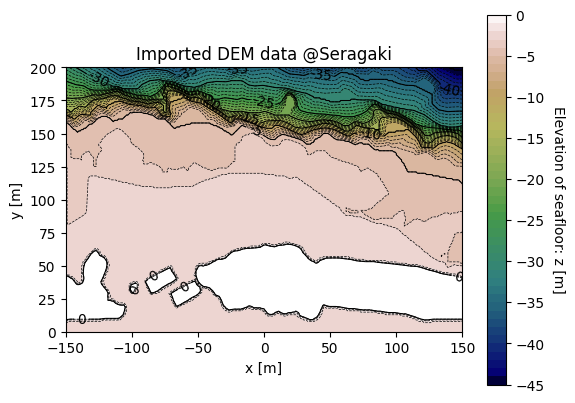

In [ ]:
"""
    Import DEM data as elevation of seafloor

"""
print('Init elevation of seafloor')

# dem data (x, y, z format w/ csv)
csv_file_path = 'seragaki.csv'
dem_data = pd.read_csv(csv_file_path)

# store x, y and z coords
x = dem_data['x']
y = dem_data['y']
z = dem_data['z']

# initialize grid system
x_unique = np.sort(dem_data['x'].unique())
y_unique = np.sort(dem_data['y'].unique())

# generate grid data
x_grid, y_grid = np.meshgrid(x_unique, y_unique)

# define as float
x_grid = x_grid.astype(float)
y_grid = y_grid.astype(float)

# init elevation (z) grid
z_grid = np.zeros_like(x_grid)

# set elevation (z-coords) grid data on xy grid system
for i in range(len(dem_data)):
    x_idx = np.where(x_unique == dem_data['x'][i])[0][0]
    y_idx = np.where(y_unique == dem_data['y'][i])[0][0]
    z_grid[y_idx, x_idx] = z[i]

print('Plot elevation of seafloor')
plt.figure()

vmin = -45
vmax = 0
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, z_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, z_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

vmin = -45
vmax = 0
num_colors = int(vmax - vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, z_grid, levels=levels, cmap='gist_earth')
cbar = plt.colorbar(contour_filled)
cbar.set_label('Elevation of seafloor: z [m]', rotation=270, labelpad=15)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'Imported DEM data {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig1_Elevation_of_seafloor.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()

Init mean water depth
Plot mean water depth


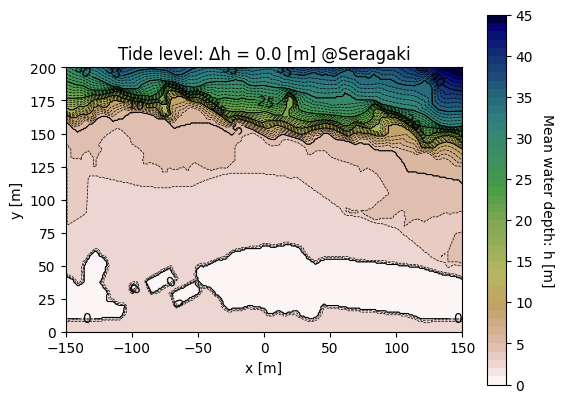

In [ ]:
"""
    Mean water depth

"""
print('Init mean water depth')

h_offset = 0.0 # [m] offset from elevation = 0 [m]
h_grid = -z_grid + h_offset

# remove negative and zero depth
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        if h_grid[i,j] < 0.0:
            h_grid[i,j] = 0.0

print('Plot mean water depth')

plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

vmin = 0
vmax = 45
num_colors = int(vmax - vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, h_grid, levels=levels, cmap='gist_earth_r')
cbar = plt.colorbar(contour_filled)
cbar.set_label('Mean water depth: h [m]', rotation=270, labelpad=15)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'Tide level: Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig2_Mean_water_depth.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
"""
    Wave parameters

"""
print('Init wave parameters')

# fluid properties
rho = 1000.0
g = 9.81

# Wave parameters input
L0 = 90.0
H0 = 2.0

# Wave parameters calculated
k0 = 2.0 * np.pi / L0
h0 = 2.0 * L0
c0 = np.sqrt((g / k0) * np.tanh(k0 * h0))
T = L0 / c0
omega = 2.0 * np.pi / T

# Energy flux
E0 = 1.0/8.0 * rho * g * H0**2
cg0 = c0 / 2.0 * (1.0 + 2.0 * k0 * h0 / np.sinh(2.0 * k0 * h0))
F = E0 * cg0

# Breaking wave height
Hb0 = 0.14 * L0

print(' Fluid properties')
print(f"  rho= {rho:.2f} [kg/m^3]")
print(f"  g  = {g:.2f} [m/s^2]")
print(' Surface displacement')
print(f"  Δh= {h_offset:.2f} [m] (input)")
print(' Deep water waves')
print(f"  L0 = {L0:.2f} [m] (input)")
print(f"  h0 = {h0:.2f} [m]")
print(f"  H0 = {H0:.2f} [m] (input)")
print(f"  Hb0= {Hb0:.2f} [m]")
print(' Dispersion relation')
print(f"  k0 = {k0:.2f} [1/m]")
print(f"  c0 = {c0:.2f} [m/s]")
print(f"  T  = {T:.2f} [s] (const)")
print(f"  ω = {omega:.2f} [1/s]")
print(' Wave energy')
print(f"  E0 = {E0:.2f} [J/m2]")
print(f"  cg0= {cg0:.2f} [m/s]")
print(f"  F  = {F:.2f} [W/m] (const)")

Init wave parameters
 Fluid properties
  rho= 1000.00 [kg/m^3]
  g  = 9.81 [m/s^2]
 Surface displacement
  Δh= 0.00 [m] (input)
 Deep water waves
  L0 = 90.00 [m] (input)
  h0 = 180.00 [m]
  H0 = 2.00 [m] (input)
  Hb0= 12.60 [m]
 Dispersion relation
  k0 = 0.07 [1/m]
  c0 = 11.85 [m/s]
  T  = 7.59 [s] (const)
  ω = 0.83 [1/s]
 Wave energy
  E0 = 4905.00 [J/m2]
  cg0= 5.93 [m/s]
  F  = 29072.00 [W/m] (const)


Solving dispersion relation with the Newton-Raphson method....
Plot phase velocity field


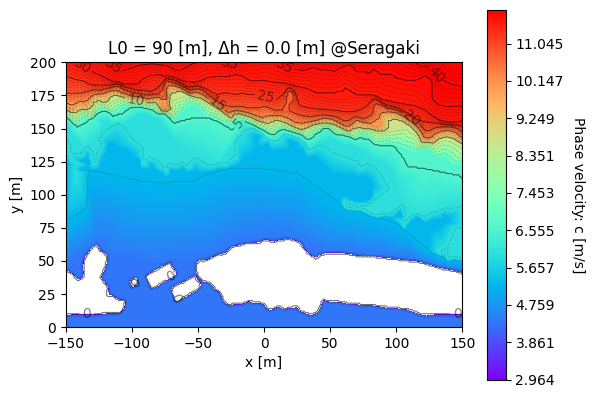

Plot group velocity field


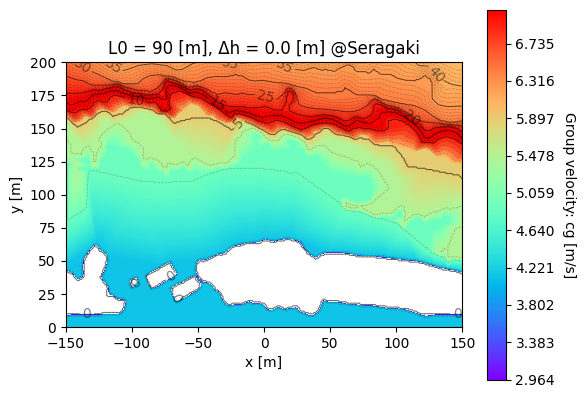

In [ ]:
"""
    Dispersion relation

"""
print("Solving dispersion relation with the Newton-Raphson method....")

k_grid = np.zeros_like(x_grid)
c_grid = np.zeros_like(x_grid)
cg_grid = np.zeros_like(x_grid)

def dispersion_relation(k):
    return omega**2 - g * k * np.tanh(k * h)

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):

        h = h_grid[i,j]

        if h < 1.0e-6:
            h = 1.0e-6

        k_initial_guess = omega**2 / g
        k_solution = fsolve(dispersion_relation, k_initial_guess)
        k = k_solution[0]

        c = np.sqrt((g / k) * np.tanh(k * h))

        cg = c / 2.0 * (1.0 + 2.0 * k * h / np.sinh(2.0 * k * h))

        k_grid[i,j] = k
        c_grid[i,j] = c
        cg_grid[i,j] = cg


print('Plot phase velocity field')
plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5, alpha=0.25)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75, alpha=0.5)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

# Plot phase velocity: c [m/s]
vmin = c0*0.25
vmax = c0*1.00
num_colors = 1001
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, c_grid, levels=levels, cmap='rainbow')
cbar = plt.colorbar(contour_filled)
cbar.set_label('Phase velocity: c [m/s]', rotation=270, labelpad=15)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'L0 = {L0:.0f} [m], Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig3_Phase_velocity.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()


print('Plot group velocity field')
plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5, alpha=0.25)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75, alpha=0.5)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

# Plot group velocity: cg [m/s]
vmin = c0*0.25
vmax = c0*0.60
num_colors = 1001
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, cg_grid, levels=levels, cmap='rainbow')
cbar = plt.colorbar(contour_filled)
cbar.set_label('Group velocity: cg [m/s]', rotation=270, labelpad=15)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'L0 = {L0:.0f} [m], Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig4_Group_velocity.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()

Solving wavefronts propagation with the Euler method....
Plot wavefronts


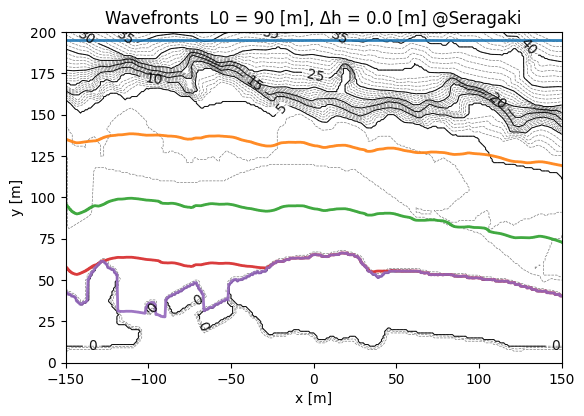

In [ ]:
"""
    Wavefronts propagation

"""
print("Solving wavefronts propagation with the Euler method....")

Np = 600            # number of nodes [-]
dt = 0.1            # [s]
Nl = 4              # number of wavefronts
Nt = Nl*int(T/dt)   # number of time step [-]

# initial wavefronts
xp = np.linspace(-150.0, 150.0, Np)
yp = np.linspace( 195.0, 195.0, Np)

# propagating direction unit vector: p
px = np.full(Np,  0.0)
py = np.full(Np, -1.0)

# trajectories of wavefronts nodes
wavefronts = []
wavefronts.append(np.vstack((xp, yp)).T)

# propagating speed of wavefronts nodes
def cp(x, y):
    x_idx = (np.abs(x_unique - x)).argmin()
    y_idx = (np.abs(y_unique - y)).argmin()
    return c_grid[y_idx, x_idx]

for n in range(Nt):
    for i in range(Np):
        vx = cp(xp[i], yp[i]) * px[i]
        vy = cp(xp[i], yp[i]) * py[i]
        xp[i] += dt * vx
        yp[i] += dt * vy
    if (n+1) % int(T/dt) == 0:
        wavefronts.append(np.vstack((xp, yp)).T) # .T as transpose


print("Plot wavefronts")

plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5, alpha=0.5)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75, alpha=0.9)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

# Plot wavefronts
for l in wavefronts:
    plt.plot(l[:, 0], l[:, 1], 'p-', linewidth=2.0, markersize=0.0, alpha=0.9)
    #plt.plot(l[:, 0], l[:, 1], 'w-', linewidth=2.0)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'Wavefronts  L0 = {L0:.0f} [m], Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig5_Wavefronts.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()

Solving wave height and breaking height....
Plot wave height field with breaking height contour lines


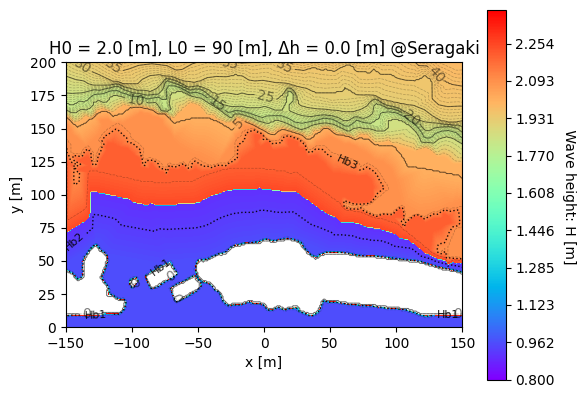

In [ ]:
"""
    Breaking wave height and breaking height

"""
print("Solving wave height and breaking height....")

H_grid = np.zeros_like(x_grid)
Hb_grid = np.zeros_like(x_grid)

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):

        cg = cg_grid[i,j]
        Ks = (cg0/cg)**0.5
        H = Ks * H0

        h = h_grid[i,j]
        L = c_grid[i,j] * T
        Hb = 0.14 * np.tanh(2.0 * np.pi * h / L) * L

        if(H > Hb):
            H *= 0.4

        H_grid[i,j] = H
        Hb_grid[i,j] = Hb


print('Plot wave height field with breaking height contour lines')
plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5, alpha=0.25)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75, alpha=0.5)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

# Plot wave height: H [m]
vmin = H0 * 0.4
vmax = H0 * 1.2
num_colors = 1001
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, H_grid, levels=levels, cmap='rainbow')
cbar = plt.colorbar(contour_filled)
cbar.set_label(' Wave height: H [m]', rotation=270, labelpad=15)

# Plot breaking height: Hb [m]
vmin = 1
vmax = 3
num_colors = int(vmax - vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, Hb_grid, levels=levels, linestyles='dotted', colors='black', linewidths=1.0, alpha=0.9)
plt.clabel(contour_lines, inline=0.1, fontsize=8, fmt='Hb%.0f')

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'H0 = {H0:.1f} [m], L0 = {L0:.0f} [m], Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig6_Wave_height_and_breaking_height.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()


Solving energy density...
Plot energy density field


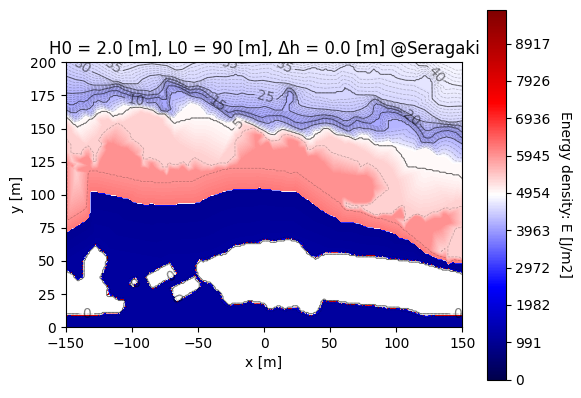

In [ ]:
"""
    Energy density

"""
print("Solving energy density...")

E_grid = np.zeros_like(x_grid)

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):

        H = H_grid[i,j]
        E = rho * g * H**2 /8.0
        E_grid[i,j] = E


# plot energy density: E [J/m]
print('Plot energy density field')
plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5, alpha=0.25)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75, alpha=0.5)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

vmin = 0.0
vmax = E0 * 2.0
num_colors = 1001
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, E_grid, levels=levels, cmap='seismic')
cbar = plt.colorbar(contour_filled)
cbar.set_label('Energy density: E [J/m2]', rotation=270, labelpad=15)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'H0 = {H0:.1f} [m], L0 = {L0:.0f} [m], Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig7_Energy_density.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()


Solving depth averaged underwater flow velocity with the Gauss-Kronrod quadrature....
Plot depth averaged underwater flow velocity field


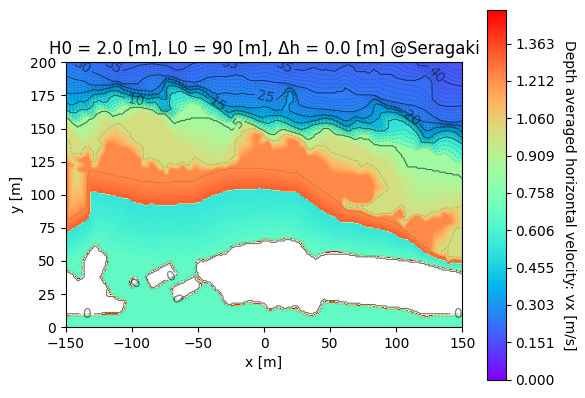

In [ ]:
"""
    Underwater flow velocity

"""
print("Solving depth averaged underwater flow velocity with the Gauss-Kronrod quadrature....")

vx_grid = np.zeros_like(x_grid)

time_avg_sin_abs = 2.0 / np.pi

def integrand_abs_z(z, k, h):
    return np.abs((H / 2.0) * (g * k / omega)  * np.cosh(k * (z + h)) / np.cosh(k * h))

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):

        h = h_grid[i,j]
        k = k_grid[i,j]
        H = H_grid[i,j]

        if h < 1.0e-6:
            h = 1.0e-6

        result, error = quad(integrand_abs_z, -h, 0.0, args=(k, h))

        vx_grid[i,j] = result / h * time_avg_sin_abs


print('Plot depth averaged underwater flow velocity field')
plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5, alpha=0.25)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75, alpha=0.5)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

# Plot underwater velocity: vx [m/s]
vmin = 0.0
vmax = 1.5
num_colors = 1001
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, vx_grid, levels=levels, cmap='rainbow')
cbar = plt.colorbar(contour_filled)
cbar.set_label('Depth averaged horizontal velocity: vx [m/s]', rotation=270, labelpad=15)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'H0 = {H0:.1f} [m], L0 = {L0:.0f} [m], Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig8_Horizontal_underwater_flow_velocity.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()

Solving wave power with the Gauss-Kronrod quadrature....
Plot wave power field


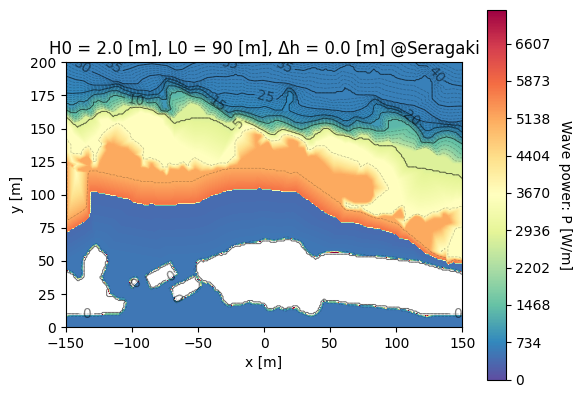

In [ ]:

"""
    Wave power

"""
print("Solving wave power with the Gauss-Kronrod quadrature....")

P_grid = np.zeros_like(x_grid)

time_avg_sin_abs_cube = 3.0 / (2.0 * np.pi)

def integrand_abs_cube_z(z, k, h):
    return np.abs((H / 2.0) * (g * k / omega) * np.cosh(k * (z + h)) / np.cosh(k * h))**3

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):

        h = h_grid[i,j]
        k = k_grid[i,j]
        H = H_grid[i,j]

        if h < 1.0e-6:
            h = 1.0e-6

        result, error = quad(integrand_abs_cube_z, -h, 0.0, args=(k, h))

        P = (rho / 2.0) * result * time_avg_sin_abs_cube

        P_grid[i,j] = P


print('Plot wave power field')
plt.figure()

# Plot depth contour lines
vmin = 0
vmax = 45
num_colors = int(vmax-vmin) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='dashed', colors='black', linewidths=0.5, alpha=0.25)
num_colors = int((vmax-vmin)/5) + 1
levels = np.linspace(vmin, vmax, num_colors)
contour_lines = plt.contour(x_grid, y_grid, h_grid, levels=levels, linestyles='solid', colors='black', linewidths=0.75, alpha=0.5)
plt.clabel(contour_lines, inline=1, fontsize=10, fmt='%1.0f')

# Plot wave power: P [W]
vmin = 0.0
vmax = F / 4.0
num_colors = 1001
levels = np.linspace(vmin, vmax, num_colors)
contour_filled = plt.contourf(x_grid, y_grid, P_grid, levels=levels, cmap='Spectral_r')
cbar = plt.colorbar(contour_filled)
cbar.set_label('Wave power: P [W/m]', rotation=270, labelpad=15)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title(f'H0 = {H0:.1f} [m], L0 = {L0:.0f} [m], Δh = {h_offset} [m] {place}')
plt.gca().set_aspect('equal', adjustable='box')

output_file_path = 'Fig9_Wave_power.png'
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()